# Telecom Churn Group Project

This notebook is split into following section

<b>* Common Function</b>
    * This section we have all the common functions which are used in the entire notebook
<b> * Basic Data Analysis and Null Value imputation </b>
    * Drop Columns with more than 50% NULL Values
    * Handle columns with less number of NULL Values
    * Drop columns having not informative information
    * Create Dummy Variables for the categorical variables.
    * Filter and get high valued customer information
    * Derived Columns based on basic column analysis
    * Create a new columns which will tell about the Churn/No-Churn customer and Drop 9th month related columns
<b> * EDA </b>
    * EDA for Month 6 and 7 Together
    * EDA for Month 8
    * Derived Columns by combining 6th, 7th and 8th columns 
    * How the features are varied from Good Period to Decision period
    * What is the average variation from 6th+7th Month to 8th Month
    * EDA for the derived columns
<b> * Data Modeling </b>
    * Data Normalization 
    * Basic Logistic Regression Fit to Check the accuracy
    * As churn count is less, basic logist can be done with GridSearch and K-Fold
    * Using PCA dimentionality reduction can be done
    * By taking the PCA data logistic regression can be done again with GridSearch and K-Fold to check for prediction.
    * Using Lasso Regression, It can be found the important features impacting the churn.
    * Using Tree Model, Also Important Features can be derived.
    * If during EDA, any variable relation found with multinomial relation, then SVM Kernel can be used for prediction.

<b> * Final Model Selection </b>
    * Final Model for Prediction
    * Final Model for important Feature selection 
<b> * Summary </b>
    * Project Analysis and Summary

In [316]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import time
import datetime

df = pd.read_csv('telecom_churn_data.csv')

# Common Function

In [352]:
# Function to Return Montwise ColumnsList
def returnColumnsByMonth(df):
    column_Month_6 = []
    column_Month_7 = []
    column_Month_8 = []
    column_Month_9 = []
    column_Common = []
    for eachColumns in df.columns:
        if((eachColumns.find("_6") >=0) | (eachColumns.find("jun_") >=0)):
            column_Month_6.append(eachColumns)
        elif((eachColumns.find("_7") >=0) | (eachColumns.find("jul_") >=0)):
            column_Month_7.append(eachColumns)
        elif((eachColumns.find("_8") >= 0) | (eachColumns.find("aug_") >=0)):
            column_Month_8.append(eachColumns)
        elif((eachColumns.find("_9") >=0) | (eachColumns.find("sep_") >=0)):
            column_Month_9.append(eachColumns)
        else:
            column_Common.append(eachColumns)
    return column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common

# Function to Get Columns Based on Null %
def getColumnsBasedOnNullPercent(df, nullPercentLimit, limitType = 'Upper'):
    col2NullPercent_df = pd.DataFrame(round((df.isnull().sum()/len(df.index))* 100, 2), columns=['NullPercent'])
    col2NullPercent_df = pd.DataFrame(round((df.isnull().sum()/len(df.index))* 100, 2), columns=['NullPercent'])
    if(limitType == 'Upper'):
        columnsList = np.array(col2NullPercent_df.apply(lambda x: x['NullPercent'] > nullPercentLimit , axis=1))
    if(limitType == 'Lower'):
        columnsList = np.array(col2NullPercent_df.apply(lambda x: ((x['NullPercent'] < nullPercentLimit) & (x['NullPercent'] > 0)) , axis=1))
    return np.array(df.loc[:, columnsList].columns)

# Function to get Days Since Last Recharge for 6/7/8/9 months
def daysSinceLastRechargeMonthwise(df, month):
    if(month == 6):
        return pd.to_datetime(df['last_date_of_month_6']) - pd.to_datetime(df['date_of_last_rech_6'])
    elif(month == 7):
        return pd.to_datetime(df['last_date_of_month_7']) - pd.to_datetime(df['date_of_last_rech_7'])
    elif(month == 8):
        return pd.to_datetime(df['last_date_of_month_8']) - pd.to_datetime(df['date_of_last_rech_8'])
    elif(month == 9):
        return pd.to_datetime(df['last_date_of_month_9']) - pd.to_datetime(df['date_of_last_rech_9'])

def plotCategoricalChurn_NotChurn(df, columnsList, flag = 0):
    for eachMonth in columnsList:
    #flag = 1        
    #eachMonth = "days_from_LastRechage_6"
        col = eachMonth
        X1 = df.groupby('churn')[col].agg(['mean']).reset_index()
        X1.rename(columns={'mean':col}, inplace=True)
        if(flag == 1):
            seventhMonth = eachMonth[:-1] + "7"
            X2 = df.groupby('churn')[seventhMonth].agg(['mean']).reset_index()    
            X2.rename(columns={'mean':seventhMonth}, inplace=True)
            X2 = pd.merge(X1,X2, on = ['churn'])
            newCol = eachMonth[:-1] + "goodPeriod_Avg"
            print(newCol)
            X2[newCol] = (X2[eachMonth] + X2[seventhMonth])/2
            p = sns.barplot(x='churn', y=newCol, data=X2)
            p.set_xticklabels(['Not-Churn','churn'], fontsize= 12)
            plt.ylabel(newCol,fontsize = 12)
            plt.xlabel('churn', fontsize = 12)
            plt.show()
            X2.head()

        else:
            print(eachMonth)
            p = sns.barplot(x='churn', y=col, data=X1)
            p.set_xticklabels(['Not-Churn','churn'], fontsize= 12)
            plt.ylabel(col,fontsize = 12)
            plt.xlabel('churn', fontsize = 12)
            plt.show()
            X1.head()
#Function to Show Howmuch % usage done for Churn Subscriber with respect to total usage on that month, for tht particular feature
# e.g: arpu (Averag Revenue Per User) ==> How much is the average arpu for churn and non-churn subscriber in month 6 7 and 8.
# Then check for churn subscriber how much % usage on total mean Usage in each month
def churnSubscriberUsageChangePercentage():
    for eachFeature in column_Month_6:
        col = eachFeature
        #col = featureCol
        X1 = df.groupby(['churn'])[col].agg(['mean']).reset_index()
        X1.rename(columns={'mean': "mean_"+col}, inplace=True)
        if(col == 'jun_vbc_3g'):
            col = 'jul_vbc_3g'
        else:
            col = col[:-1] + "7"
        X2 = df.groupby(['churn'])[col].agg(['mean']).reset_index()
        X2.rename(columns={'mean': "mean_"+col}, inplace=True)
        if(col == 'jul_vbc_3g'):
            col = 'aug_vbc_3g'
        else:
            col = col[:-1] + "8"
        X3 = df.groupby(['churn'])[col].agg(['mean']).reset_index()
        X3.rename(columns={'mean': "mean_"+col}, inplace=True)

        X1 = pd.merge(X1, X2, on = ['churn'])
        X1 = pd.merge(X1,X3, on = ['churn'])
        X1.head()
        X1 = X1.transpose().reset_index()
        X1 = X1.loc[1:]
        X1.columns = ['Feature', 'Not-Churn', 'Churn']
        #X1.head()
        X1['Usage%_During_Churn'] = round((X1['Churn']/(X1['Not-Churn'] + X1['Churn']))*100,2)
        print(X1.head())
        plt.figure(figsize=(12, 6))
        ax = plt.subplot(111)
        p = sns.barplot(x='Feature', y='Usage%_During_Churn', data=X1)
        p.set_xticklabels(p.get_xticklabels(),rotation=45)
        plt.title('Churn subscriber usage to Total Usage % for {}'.format(col[:-2]), fontsize = 12)
        X1.rename(columns={'Usage%_During_Churn':'Churn_Subscriber_Usage_Trend'}, inplace=True)
        plt.plot(X1['Churn_Subscriber_Usage_Trend'], 'r-')
        #plt.title(title, fontsize = 12)
        ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.00), shadow=True, ncol=2, fontsize = 10)
        plt.show()

# Basic Data Analysis and Null Value Imputation

In [318]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [319]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

####  * Get Columns Monthwise & Basic Understanding of Columns

In [320]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))

Month 6 Columns Count ==> 55
Month 7 Columns Count ==> 55
Month 8 Columns Count ==> 55
Month 9 Columns Count ==> 55
Common Columns Count ==> 6


In [321]:
# All Months are having same type of columns So lets see the columns in general
print ("\nMonth based Columns:\n \t\t==> {}".format(np.array(column_Month_6)))
print ("\nCommon Columns:\n \t\t==> {}".format(np.array(column_Common)))


Month based Columns:
 		==> ['last_date_of_month_6' 'arpu_6' 'onnet_mou_6' 'offnet_mou_6'
 'roam_ic_mou_6' 'roam_og_mou_6' 'loc_og_t2t_mou_6' 'loc_og_t2m_mou_6'
 'loc_og_t2f_mou_6' 'loc_og_t2c_mou_6' 'loc_og_mou_6' 'std_og_t2t_mou_6'
 'std_og_t2m_mou_6' 'std_og_t2f_mou_6' 'std_og_t2c_mou_6' 'std_og_mou_6'
 'isd_og_mou_6' 'spl_og_mou_6' 'og_others_6' 'total_og_mou_6'
 'loc_ic_t2t_mou_6' 'loc_ic_t2m_mou_6' 'loc_ic_t2f_mou_6' 'loc_ic_mou_6'
 'std_ic_t2t_mou_6' 'std_ic_t2m_mou_6' 'std_ic_t2f_mou_6'
 'std_ic_t2o_mou_6' 'std_ic_mou_6' 'total_ic_mou_6' 'spl_ic_mou_6'
 'isd_ic_mou_6' 'ic_others_6' 'total_rech_num_6' 'total_rech_amt_6'
 'max_rech_amt_6' 'date_of_last_rech_6' 'last_day_rch_amt_6'
 'date_of_last_rech_data_6' 'total_rech_data_6' 'max_rech_data_6'
 'count_rech_2g_6' 'count_rech_3g_6' 'av_rech_amt_data_6' 'vol_2g_mb_6'
 'vol_3g_mb_6' 'arpu_3g_6' 'arpu_2g_6' 'night_pck_user_6' 'monthly_2g_6'
 'sachet_2g_6' 'monthly_3g_6' 'sachet_3g_6' 'fb_user_6' 'jun_vbc_3g']

Common Columns:
 		==

#### * Derive Columns Total_Recharge_Amount from 6th and 7th Month total_rech_amt

In [322]:
df['Total_Recharge_Amount'] = df['total_rech_amt_6'] + df['total_rech_amt_7']

# Get 70% of "Total Recharge Amount" to identify the recharge Amount Range for High value customer
print(df['Total_Recharge_Amount'].describe(percentiles = [0.7]))
print("\n70% of Total Recharge Amount of first 2 months are {}".format(df['Total_Recharge_Amount'].describe(percentiles = [0.7])[5]))

count    99999.000000
mean       650.477585
std        741.666932
min          0.000000
50%        458.000000
70%        737.000000
max      75525.000000
Name: Total_Recharge_Amount, dtype: float64

70% of Total Recharge Amount of first 2 months are 737.0


#### * Filter High Value Customer from main data frame

In [323]:
df = df[df['Total_Recharge_Amount'] > 737].reset_index(drop=True)
print("\nTotal High Value Customer Count ==> {}".format(df.shape[0]))
df.drop(columns=['Total_Recharge_Amount'], inplace=True)


Total High Value Customer Count ==> 29979


#### * Null Value Checking and Drop High Null Value Columns

In [324]:
#Get Null Percentage in dataFrame and Filter
nullPercentageLimit = 50
columns_More_Than_50_PercentNull = getColumnsBasedOnNullPercent(df,nullPercentageLimit)
#Drop Columns with More than 50% NUll
df = df.loc[:, ~df.columns.isin(columns_More_Than_50_PercentNull)]

print("\nColumn List Dropped with More than 50% of Null Value:==>\n {}\n".format(columns_More_Than_50_PercentNull))


Column List Dropped with More than 50% of Null Value:==>
 ['date_of_last_rech_data_6' 'date_of_last_rech_data_7'
 'date_of_last_rech_data_8' 'date_of_last_rech_data_9' 'total_rech_data_6'
 'total_rech_data_7' 'total_rech_data_8' 'total_rech_data_9'
 'max_rech_data_6' 'max_rech_data_7' 'max_rech_data_8' 'max_rech_data_9'
 'count_rech_2g_6' 'count_rech_2g_7' 'count_rech_2g_8' 'count_rech_2g_9'
 'count_rech_3g_6' 'count_rech_3g_7' 'count_rech_3g_8' 'count_rech_3g_9'
 'av_rech_amt_data_6' 'av_rech_amt_data_7' 'av_rech_amt_data_8'
 'av_rech_amt_data_9' 'arpu_3g_6' 'arpu_3g_7' 'arpu_3g_8' 'arpu_3g_9'
 'arpu_2g_6' 'arpu_2g_7' 'arpu_2g_8' 'arpu_2g_9' 'night_pck_user_6'
 'night_pck_user_7' 'night_pck_user_8' 'night_pck_user_9' 'fb_user_6'
 'fb_user_7' 'fb_user_8' 'fb_user_9']



#### * Check Categorical Variables and Single Record Variables

In [325]:
singleCategoryColumns = df.loc[:, np.array(df.apply(lambda x: x.nunique() == 1))].columns
for eachSingleCatgory in singleCategoryColumns:
    print("{}: {}".format(eachSingleCatgory, df[eachSingleCatgory].unique()))
print("\n<=== Drop Single Category Columns, Other than last_date_of_month_6/7/8/9, as it will be used for Derive Columns ===>\n")
singleCategoryColumns = [x for x in singleCategoryColumns if x not in list(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9'])]
singleCategoryColumns = np.array(singleCategoryColumns)
df = df.loc[:, ~df.columns.isin(singleCategoryColumns)]
df['last_date_of_month_7'] = df['last_date_of_month_7'].fillna('7/31/2014')
df['last_date_of_month_8'] = df['last_date_of_month_8'].fillna('8/31/2014')
df['last_date_of_month_9'] = df['last_date_of_month_9'].fillna('9/30/2014')

circle_id: [109]
loc_og_t2o_mou: [ 0. nan]
std_og_t2o_mou: [ 0. nan]
loc_ic_t2o_mou: [ 0. nan]
last_date_of_month_6: ['6/30/2014']
last_date_of_month_7: ['7/31/2014' nan]
last_date_of_month_8: ['8/31/2014' nan]
last_date_of_month_9: ['9/30/2014' nan]
std_og_t2c_mou_6: [ 0. nan]
std_og_t2c_mou_7: [ 0. nan]
std_og_t2c_mou_8: [ 0. nan]
std_og_t2c_mou_9: [nan  0.]
std_ic_t2o_mou_6: [ 0. nan]
std_ic_t2o_mou_7: [ 0. nan]
std_ic_t2o_mou_8: [ 0. nan]
std_ic_t2o_mou_9: [nan  0.]

<=== Drop Single Category Columns, Other than last_date_of_month_6/7/8/9, as it will be used for Derive Columns ===>



#### * Analyze Null Value for Less than 50%

In [326]:
columns_Less_Than_50_PercentNull = getColumnsBasedOnNullPercent(df,nullPercentageLimit, limitType='Lower')
df_temp = df.loc[:, columns_Less_Than_50_PercentNull]
round(df_temp.isnull().sum()/len(df_temp.index) * 100,2)

onnet_mou_6            1.05
onnet_mou_7            1.01
onnet_mou_8            3.13
onnet_mou_9            5.68
offnet_mou_6           1.05
offnet_mou_7           1.01
offnet_mou_8           3.13
offnet_mou_9           5.68
roam_ic_mou_6          1.05
roam_ic_mou_7          1.01
roam_ic_mou_8          3.13
roam_ic_mou_9          5.68
roam_og_mou_6          1.05
roam_og_mou_7          1.01
roam_og_mou_8          3.13
roam_og_mou_9          5.68
loc_og_t2t_mou_6       1.05
loc_og_t2t_mou_7       1.01
loc_og_t2t_mou_8       3.13
loc_og_t2t_mou_9       5.68
loc_og_t2m_mou_6       1.05
loc_og_t2m_mou_7       1.01
loc_og_t2m_mou_8       3.13
loc_og_t2m_mou_9       5.68
loc_og_t2f_mou_6       1.05
loc_og_t2f_mou_7       1.01
loc_og_t2f_mou_8       3.13
loc_og_t2f_mou_9       5.68
loc_og_t2c_mou_6       1.05
loc_og_t2c_mou_7       1.01
                       ... 
std_ic_t2t_mou_8       3.13
std_ic_t2t_mou_9       5.68
std_ic_t2m_mou_6       1.05
std_ic_t2m_mou_7       1.01
std_ic_t2m_mou_8    

#### * As the Null % is very less, lets see if Null Value Can be imputed with some value

In [327]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df_temp)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))
print("==> All Months are having same columns with less% of Null Value")
print(np.array(column_Month_7))
df_temp.loc[:, column_Month_7].head()

Month 6 Columns Count ==> 28
Month 7 Columns Count ==> 28
Month 8 Columns Count ==> 28
Month 9 Columns Count ==> 28
Common Columns Count ==> 0
==> All Months are having same columns with less% of Null Value
['onnet_mou_7' 'offnet_mou_7' 'roam_ic_mou_7' 'roam_og_mou_7'
 'loc_og_t2t_mou_7' 'loc_og_t2m_mou_7' 'loc_og_t2f_mou_7'
 'loc_og_t2c_mou_7' 'loc_og_mou_7' 'std_og_t2t_mou_7' 'std_og_t2m_mou_7'
 'std_og_t2f_mou_7' 'std_og_mou_7' 'isd_og_mou_7' 'spl_og_mou_7'
 'og_others_7' 'loc_ic_t2t_mou_7' 'loc_ic_t2m_mou_7' 'loc_ic_t2f_mou_7'
 'loc_ic_mou_7' 'std_ic_t2t_mou_7' 'std_ic_t2m_mou_7' 'std_ic_t2f_mou_7'
 'std_ic_mou_7' 'spl_ic_mou_7' 'isd_ic_mou_7' 'ic_others_7'
 'date_of_last_rech_7']


,onnet_mou_7,offnet_mou_7,roam_ic_mou_7,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,std_og_t2t_mou_7,...,loc_ic_t2f_mou_7,loc_ic_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7,std_ic_mou_7,spl_ic_mou_7,isd_ic_mou_7,ic_others_7,date_of_last_rech_7
0,54.68,567.16,33.49,12.59,31.38,447.38,55.14,0.0,533.91,23.29,...,101.46,355.23,11.83,126.99,34.24,173.08,0.0,14.53,15.19,7/25/2014
1,351.03,80.63,0.00,0.00,217.59,70.58,0.00,0.0,288.18,133.43,...,0.00,23.83,0.58,4.08,0.00,4.66,0.0,0.00,0.00,7/31/2014
2,108.39,119.28,144.24,35.26,6.19,47.28,0.00,0.0,53.48,85.98,...,0.00,26.11,38.29,29.79,0.00,68.09,0.0,62.11,16.24,7/22/2014
3,74.01,229.74,2.83,17.74,65.16,145.99,4.48,0.0,215.64,2.58,...,8.68,229.83,78.64,73.08,0.00,151.73,0.0,0.00,0.00,7/31/2014
4,9.28,0.00,4.76,8.46,0.00,0.00,0.00,0.0,0.00,0.81,...,0.00,2.31,0.00,0.00,0.00,0.00,0.0,0.00,0.00,7/30/2014


#### * One derive column for each month from the date columns and drop the date column, then impute NULL for derive column with 30 days

In [328]:
# 4 Derive Columns for each month, which will tell before how many days from month end, recahrge happened by subscriber.
df['days_from_LastRechage_6'] = daysSinceLastRechargeMonthwise(df, 6).apply(lambda x: x.days)
df['days_from_LastRechage_7'] = daysSinceLastRechargeMonthwise(df, 7).apply(lambda x: x.days)
df['days_from_LastRechage_8'] = daysSinceLastRechargeMonthwise(df, 8).apply(lambda x: x.days)
df['days_from_LastRechage_9'] = daysSinceLastRechargeMonthwise(df, 9).apply(lambda x: x.days)
df['days_from_LastRechage_6'] = df['days_from_LastRechage_6'].fillna(30)
df['days_from_LastRechage_7'] = df['days_from_LastRechage_7'].fillna(30)
df['days_from_LastRechage_8'] = df['days_from_LastRechage_8'].fillna(30)
df['days_from_LastRechage_9'] = df['days_from_LastRechage_9'].fillna(30)

In [329]:
#Drop the last Recharge Date and End date of the month columns for all the months
dateColumns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8','last_date_of_month_9',
              'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']
df = df.loc[:, ~df.columns.isin(dateColumns)]

#### * Fill Other NULL field with value 0 (Need to check further if any special logic need to put)

In [330]:
df = df.fillna(0).reset_index()

#### * Derive a Column which will tell if subscriber is churn or not churn

In [331]:
# Label churn and non-churn customers
df['churn'] = np.where(
            (
                (df['total_ic_mou_9'] == 0.0) | 
                (df['total_og_mou_9'] == 0.0)
            ) & 
            (
                (df['vol_2g_mb_9'] == 0.0) & 
                (df['vol_3g_mb_9'] == 0.0)
            ),1,0
        )

#### * Drop 9th Month Columns

In [332]:
# Remove columns with '9'
df = df.drop(df.filter(like = '9').columns, axis=1)

# EDA and Derive Columns

In [333]:
#### * EDA For Month 6 Feature (Good Period)
#EDA For Month6 Columns
#plotCategoricalChurn_NotChurn(df, column_Month_6)

#### * EDA For Month 7 features (Good Period)
#EDA For Month7 Columns
#plotCategoricalChurn_NotChurn(df, column_Month_7)

#### * EDA For Month 8 Feature (Decision Month)
#EDA For Month8 Columns
#plotCategoricalChurn_NotChurn(df, column_Month_8)

#### * EDA For Month 6 Month 7 ``Feature Average Value`` (Good Period)
#EDA For Month 6 Month 7 Value Average
#plotCategoricalChurn_NotChurn(df, column_Month_8 , flag=1)

#### * Derive Columns

* Column Analysis for Derive Columns
                   total_og_mou_6/7/8 = loc_og_mou_6/7/8 +  std_og_mou_6/7/8 + spl_og_mou_6/7/8 + og_others_6/7/8
                   total_ic_mou_6/7/8 = loc_ic_mou_6/7/8 + std_ic_mou_6/7/8 + spl_ic_mou_6/7/8 + ic_others_6/7/8
* Derive Columns
             loc_og_mou_Percent_6/7/8, std_og_mou_Percent_6/7/8, spl_og_mou_Percent_6/7/8, og_others_Percent_6/7/8
             loc_ic_mou_Percent_6/7/8, std_ic_mou_Percent_6/7/8, spl_ic_mou_Percent_6/7/8, ic_others_Percent_6/7/8

In [334]:
df['loc_og_mou_Percent_6'] = round((df['loc_og_mou_6']/df['total_og_mou_6']) * 100,2)
df['std_og_mou_Percent_6'] = round((df['std_og_mou_6']/df['total_og_mou_6']) * 100,2)
df['spl_og_mou_Percent_6'] = round((df['spl_og_mou_6']/df['total_og_mou_6']) * 100,2)
df['og_others_Percent_6'] = round((df['og_others_6']/df['total_og_mou_6']) * 100,2)
df['loc_ic_mou_Percent_6'] = round((df['loc_ic_mou_6']/df['total_ic_mou_6']) * 100,2)
df['std_ic_mou_Percent_6'] = round((df['std_ic_mou_6']/df['total_ic_mou_6']) * 100,2)
df['spl_ic_mou_Percent_6'] = round((df['spl_ic_mou_6']/df['total_ic_mou_6']) * 100,2)
df['ic_others_Percent_6'] = round((df['ic_others_6']/df['total_ic_mou_6']) * 100,2)

df['loc_og_mou_Percent_7'] = round((df['loc_og_mou_7']/df['total_og_mou_7']) * 100,2)
df['std_og_mou_Percent_7'] = round((df['std_og_mou_7']/df['total_og_mou_7']) * 100,2)
df['spl_og_mou_Percent_7'] = round((df['spl_og_mou_7']/df['total_og_mou_7']) * 100,2)
df['og_others_Percent_7'] = round((df['og_others_7']/df['total_og_mou_7']) * 100,2)
df['loc_ic_mou_Percent_7'] = round((df['loc_ic_mou_7']/df['total_ic_mou_7']) * 100,2)
df['std_ic_mou_Percent_7'] = round((df['std_ic_mou_7']/df['total_ic_mou_7']) * 100,2)
df['spl_ic_mou_Percent_7'] = round((df['spl_ic_mou_7']/df['total_ic_mou_7']) * 100,2)
df['ic_others_Percent_7'] = round((df['ic_others_7']/df['total_ic_mou_7']) * 100,2)

df['loc_og_mou_Percent_8'] = round((df['loc_og_mou_8']/df['total_og_mou_8']) * 100,2)
df['std_og_mou_Percent_8'] = round((df['std_og_mou_8']/df['total_og_mou_8']) * 100,2)
df['spl_og_mou_Percent_8'] = round((df['spl_og_mou_8']/df['total_og_mou_8']) * 100,2)
df['og_others_Percent_8'] = round((df['og_others_8']/df['total_og_mou_8']) * 100,2)
df['loc_ic_mou_Percent_8'] = round((df['loc_ic_mou_8']/df['total_ic_mou_8']) * 100,2)
df['std_ic_mou_Percent_8'] = round((df['std_ic_mou_8']/df['total_ic_mou_8']) * 100,2)
df['spl_ic_mou_Percent_8'] = round((df['spl_ic_mou_8']/df['total_ic_mou_8']) * 100,2)
df['ic_others_Percent_8'] = round((df['ic_others_8']/df['total_ic_mou_8']) * 100,2)

# Fill All Nan Value because of 0 division set to 0.
df = df.fillna(0).reset_index()

In [335]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))
print("==> All Months are having same columns with less% of Null Value")
print(np.array(column_Month_7))
df.loc[:, column_Month_7].head()

Month 6 Columns Count ==> 50
Month 7 Columns Count ==> 50
Month 8 Columns Count ==> 50
Month 9 Columns Count ==> 1
Common Columns Count ==> 5
==> All Months are having same columns with less% of Null Value
['arpu_7' 'onnet_mou_7' 'offnet_mou_7' 'roam_ic_mou_7' 'roam_og_mou_7'
 'loc_og_t2t_mou_7' 'loc_og_t2m_mou_7' 'loc_og_t2f_mou_7'
 'loc_og_t2c_mou_7' 'loc_og_mou_7' 'std_og_t2t_mou_7' 'std_og_t2m_mou_7'
 'std_og_t2f_mou_7' 'std_og_mou_7' 'isd_og_mou_7' 'spl_og_mou_7'
 'og_others_7' 'total_og_mou_7' 'loc_ic_t2t_mou_7' 'loc_ic_t2m_mou_7'
 'loc_ic_t2f_mou_7' 'loc_ic_mou_7' 'std_ic_t2t_mou_7' 'std_ic_t2m_mou_7'
 'std_ic_t2f_mou_7' 'std_ic_mou_7' 'total_ic_mou_7' 'spl_ic_mou_7'
 'isd_ic_mou_7' 'ic_others_7' 'total_rech_num_7' 'total_rech_amt_7'
 'max_rech_amt_7' 'last_day_rch_amt_7' 'vol_2g_mb_7' 'vol_3g_mb_7'
 'monthly_2g_7' 'sachet_2g_7' 'monthly_3g_7' 'sachet_3g_7' 'jul_vbc_3g'
 'days_from_LastRechage_7' 'loc_og_mou_Percent_7' 'std_og_mou_Percent_7'
 'spl_og_mou_Percent_7' 'og_others_Pe

,arpu_7,onnet_mou_7,offnet_mou_7,roam_ic_mou_7,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,...,jul_vbc_3g,days_from_LastRechage_7,loc_og_mou_Percent_7,std_og_mou_Percent_7,spl_og_mou_Percent_7,og_others_Percent_7,loc_ic_mou_Percent_7,std_ic_mou_Percent_7,spl_ic_mou_Percent_7,ic_others_Percent_7
0,1349.850,54.68,567.16,33.49,12.59,31.38,447.38,55.14,0.0,533.91,...,19.38,6.0,87.64,12.33,0.00,0.0,63.66,31.02,0.0,2.72
1,492.223,351.03,80.63,0.00,0.00,217.59,70.58,0.00,0.0,288.18,...,910.65,0.0,66.76,33.24,0.00,0.0,83.64,16.36,0.0,0.00
2,205.671,108.39,119.28,144.24,35.26,6.19,47.28,0.00,0.0,53.48,...,0.00,9.0,27.79,72.21,0.00,0.0,15.13,39.45,0.0,9.41
3,299.869,74.01,229.74,2.83,17.74,65.16,145.99,4.48,0.0,215.64,...,2.45,0.0,75.40,23.46,1.14,0.0,60.23,39.77,0.0,0.00
4,18.980,9.28,0.00,4.76,8.46,0.00,0.00,0.00,0.0,0.00,...,0.00,1.0,0.00,100.00,0.00,0.0,100.00,0.00,0.0,0.00


#### * EDA For all the features (Monthly Featues) to find how much % usage for each feature monthwise for Churn Subscriber on total usage

       Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_arpu_6  579.100916  667.136565                53.53
2  mean_arpu_7  594.462373  542.204599                47.70
3  mean_arpu_8  566.533566  240.127416                29.77


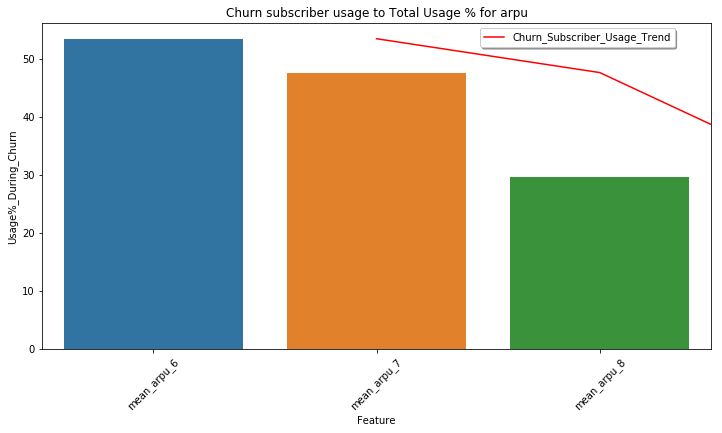

            Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_onnet_mou_6  285.228165  399.419889                58.34
2  mean_onnet_mou_7  303.911379  310.970893                50.57
3  mean_onnet_mou_8  283.675175  119.091218                29.57


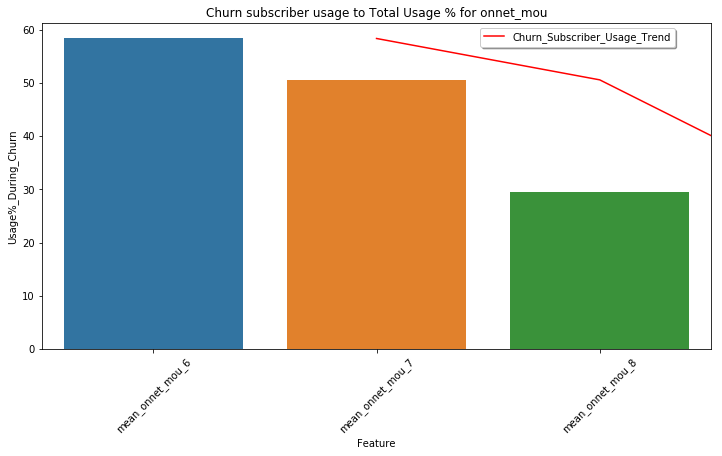

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_offnet_mou_6  409.124991  502.513744                55.12
2  mean_offnet_mou_7  426.049209  405.865118                48.79
3  mean_offnet_mou_8  399.125164  150.525215                27.39


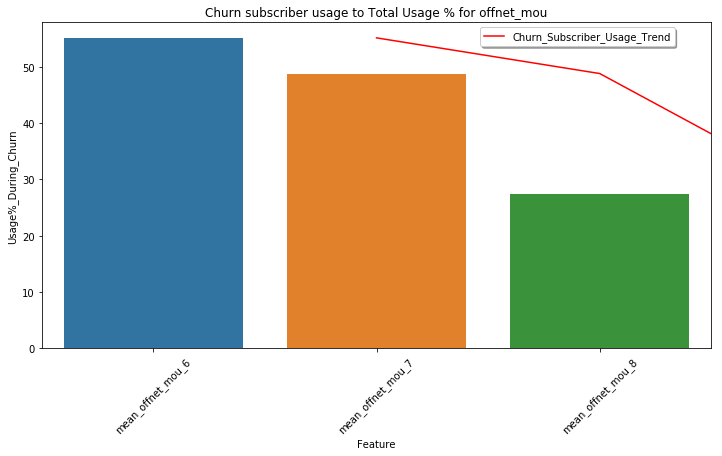

              Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_roam_ic_mou_6  16.236956  28.592834                63.78
2  mean_roam_ic_mou_7  11.936211  28.523813                70.50
3  mean_roam_ic_mou_8  11.918812  25.863318                68.45


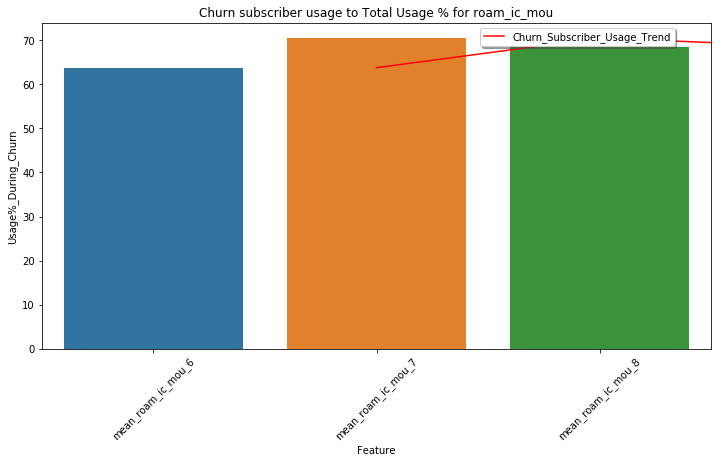

              Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_roam_og_mou_6  26.969581  51.645522                65.69
2  mean_roam_og_mou_7  19.245387  48.405287                71.55
3  mean_roam_og_mou_8  19.164140  43.224118                69.28


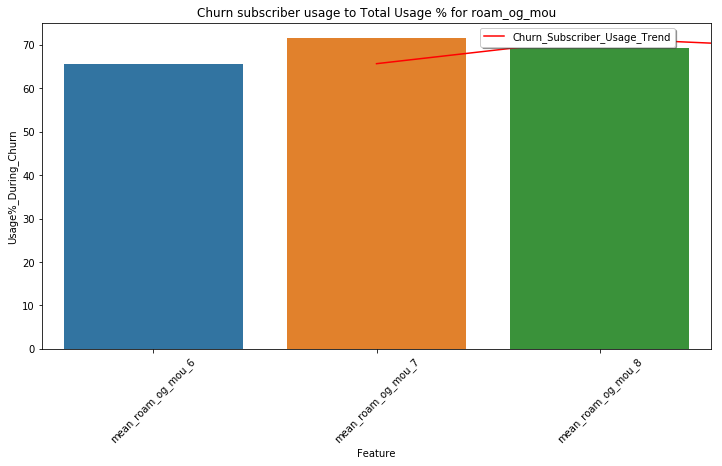

                 Feature   Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_og_t2t_mou_6   97.748689  66.471699                40.48
2  mean_loc_og_t2t_mou_7  100.858115  48.257990                32.36
3  mean_loc_og_t2t_mou_8   94.592089  17.751176                15.80


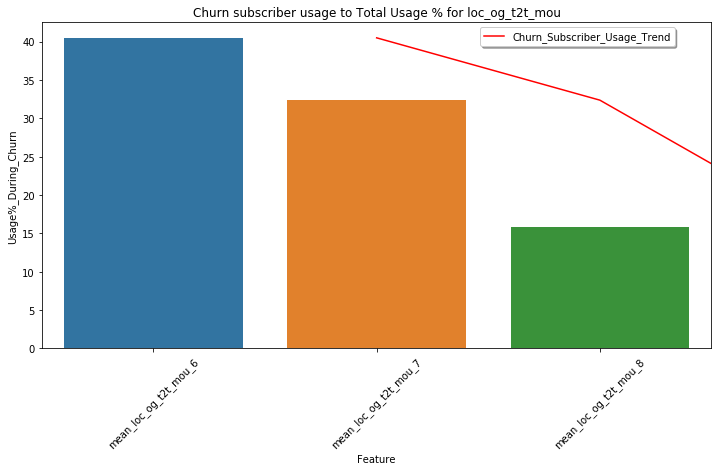

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_og_t2m_mou_6  187.394050  124.559536                39.93
2  mean_loc_og_t2m_mou_7  190.213292   97.997076                34.00
3  mean_loc_og_t2m_mou_8  181.526483   37.235824                17.02


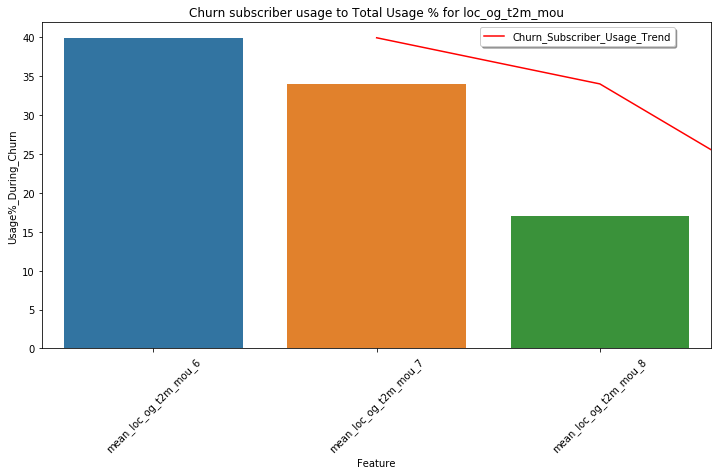

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_og_t2f_mou_6   7.335599  3.638529                33.16
2  mean_loc_og_t2f_mou_7   7.519491  3.169488                29.65
3  mean_loc_og_t2f_mou_8   7.035869  1.436529                16.96


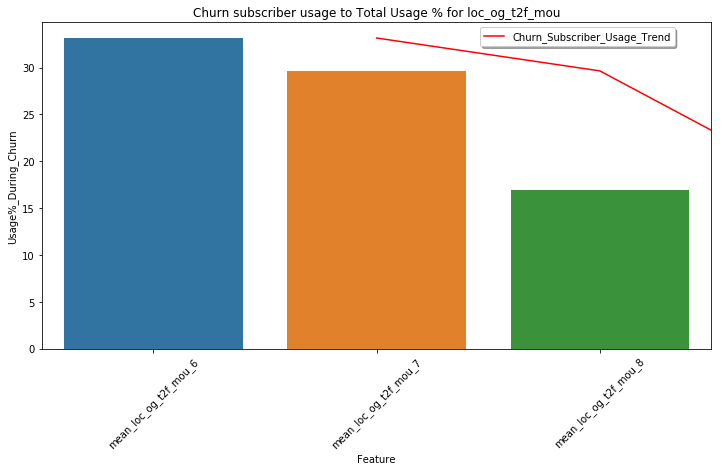

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_og_t2c_mou_6   1.552624  1.709260                52.40
2  mean_loc_og_t2c_mou_7   1.844642  2.043270                52.55
3  mean_loc_og_t2c_mou_8   1.798919  0.918561                33.80


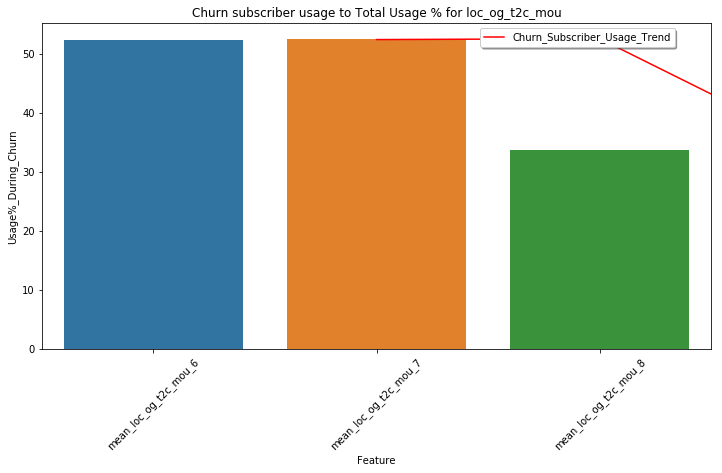

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_og_mou_6  292.487316  194.676952                39.96
2  mean_loc_og_mou_7  298.600130  149.431073                33.35
3  mean_loc_og_mou_8  283.163427   56.426740                16.62


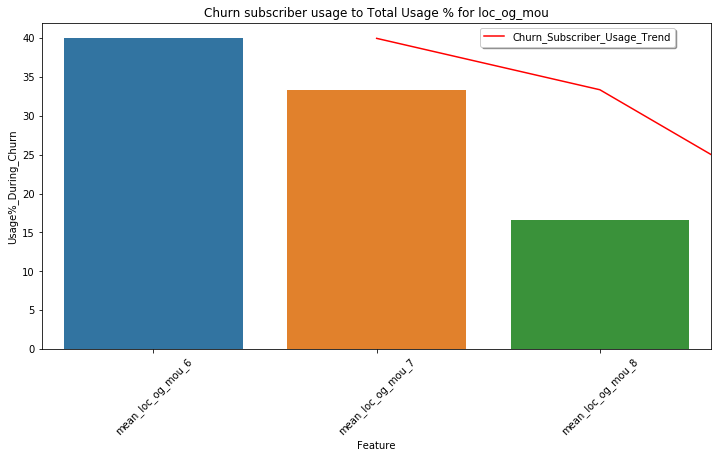

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_t2t_mou_6  176.910942  311.568457                63.78
2  mean_std_og_t2t_mou_7  195.477452  243.022827                55.42
3  mean_std_og_t2t_mou_8  181.839590   83.454979                31.46


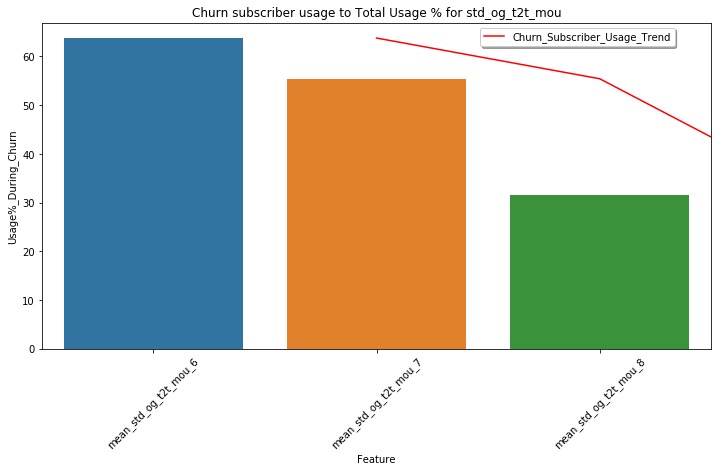

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_t2m_mou_6  189.257808  334.005090                63.83
2  mean_std_og_t2m_mou_7  207.699928  268.039716                56.34
3  mean_std_og_t2m_mou_8  189.920509   83.539263                30.55


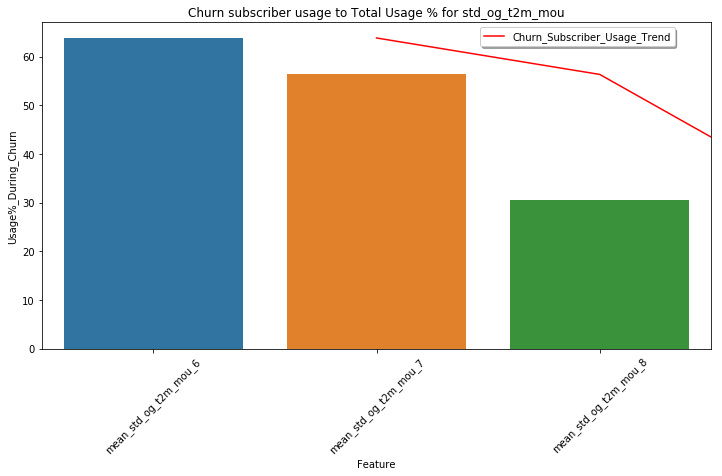

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_std_og_t2f_mou_6   2.102660  1.162920                35.61
2  mean_std_og_t2f_mou_7   2.141403  1.046913                32.84
3  mean_std_og_t2f_mou_8   1.941105  0.383343                16.49


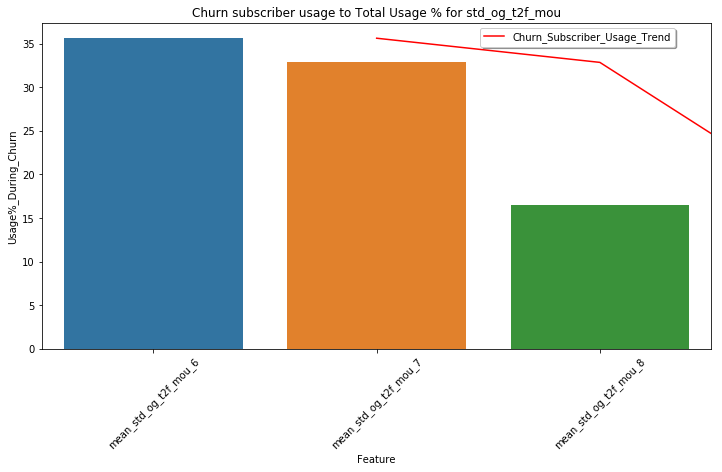

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_mou_6  368.275709  646.741111                63.72
2  mean_std_og_mou_7  405.323110  512.113813                55.82
3  mean_std_og_mou_8  373.705318  167.379481                30.93


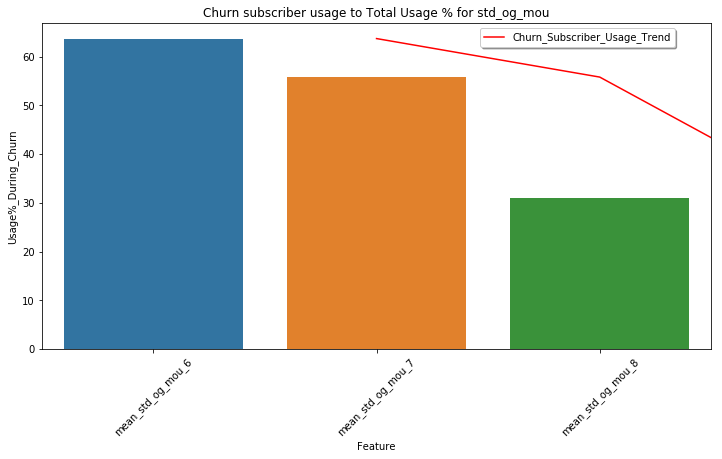

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_isd_og_mou_6   2.082636  3.993474                65.72
2  mean_isd_og_mou_7   2.134841  2.891938                57.53
3  mean_isd_og_mou_8   2.127265  1.114931                34.39


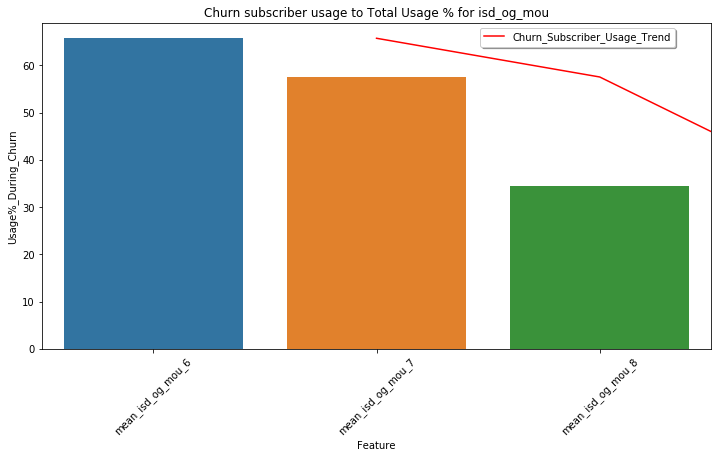

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_og_mou_6   5.795734  7.092318                55.03
2  mean_spl_og_mou_7   7.388914  7.813270                51.40
3  mean_spl_og_mou_8   7.299632  3.043858                29.43


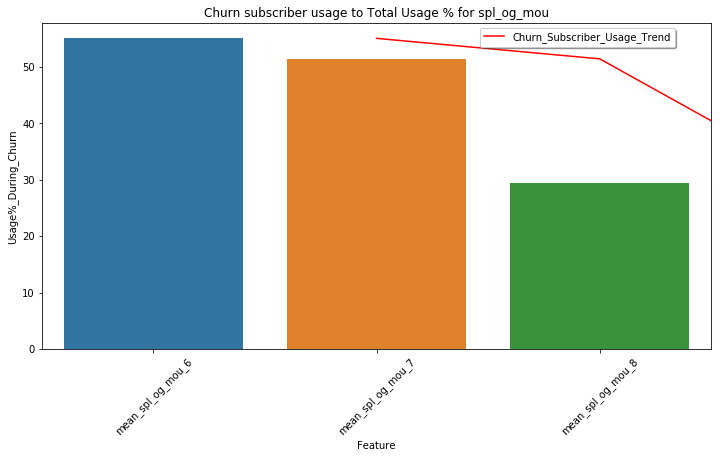

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_og_others_6   0.673006  0.882481                56.73
2  mean_og_others_7   0.037492  0.142875                79.21
3  mean_og_others_8   0.052457  0.122346                69.99


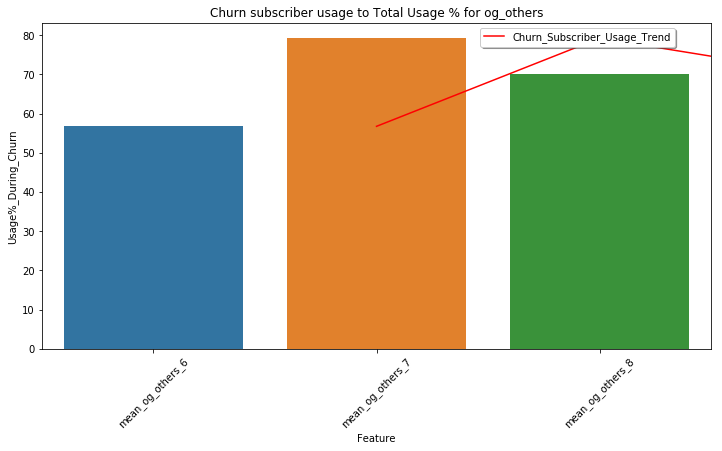

               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_og_mou_6  669.324184  853.396702                56.04
2  mean_total_og_mou_7  713.493307  672.401204                48.52
3  mean_total_og_mou_8  666.356815  228.091595                25.50


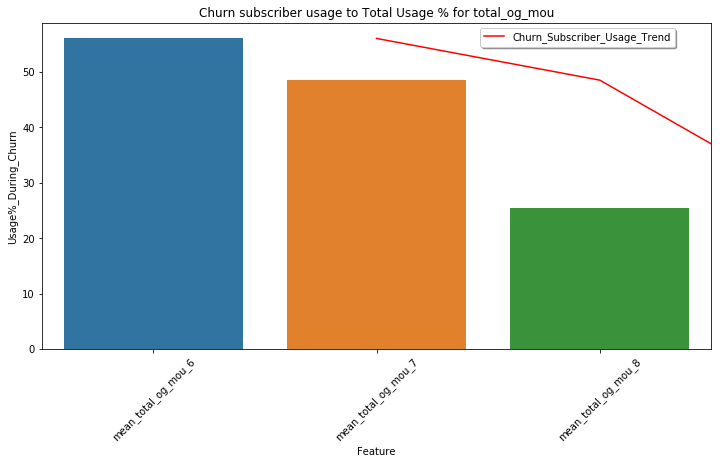

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_ic_t2t_mou_6  70.943867  48.411329                40.56
2  mean_loc_ic_t2t_mou_7  73.696129  38.767059                34.47
3  mean_loc_ic_t2t_mou_8  71.453281  14.459471                16.83


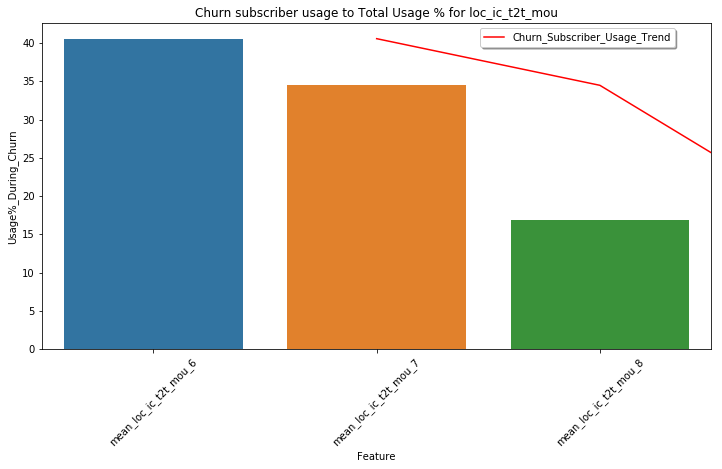

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_ic_t2m_mou_6  164.383205  115.581446                41.28
2  mean_loc_ic_t2m_mou_7  168.288822   91.184536                35.14
3  mean_loc_ic_t2m_mou_8  166.320172   34.882526                17.34


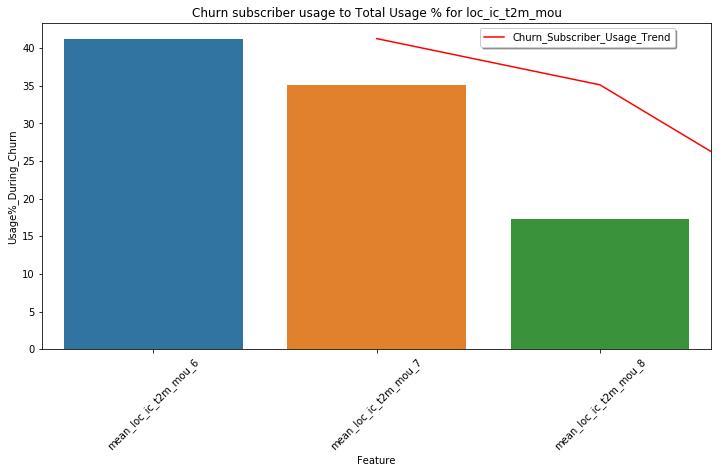

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_ic_t2f_mou_6  16.423168  7.932048                32.57
2  mean_loc_ic_t2f_mou_7  17.478314  7.526163                30.10
3  mean_loc_ic_t2f_mou_8  15.965126  2.975696                15.71


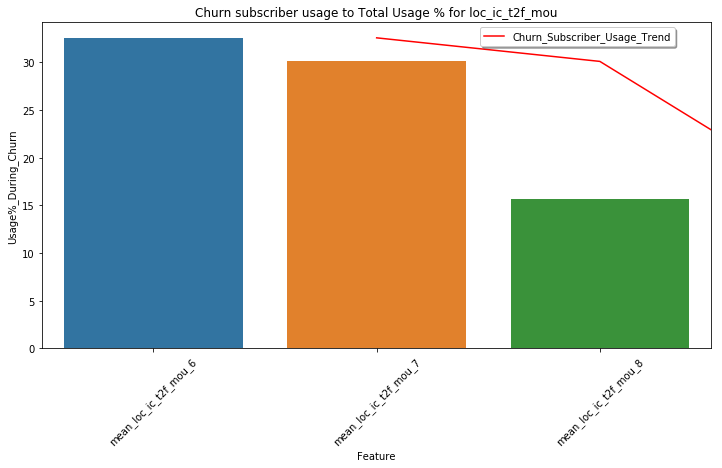

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_ic_mou_6  251.760287  171.932803                40.58
2  mean_loc_ic_mou_7  259.473565  137.484934                34.63
3  mean_loc_ic_mou_8  253.748761   52.321651                17.09


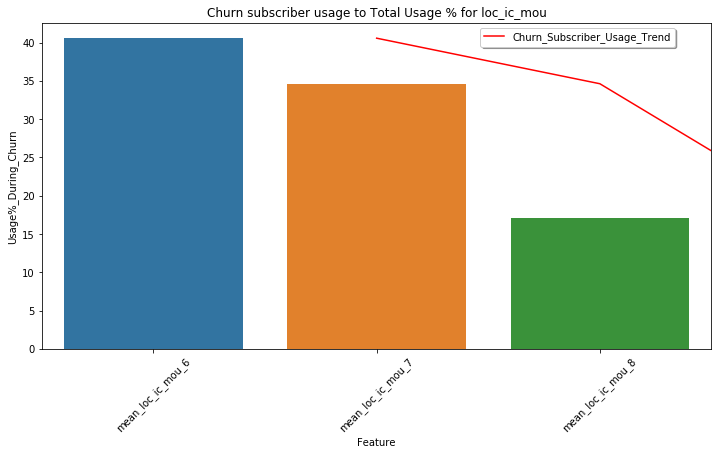

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_t2t_mou_6  15.739238  20.916301                57.06
2  mean_std_ic_t2t_mou_7  17.005585  15.972986                48.43
3  mean_std_ic_t2t_mou_8  16.130609   5.038893                23.80


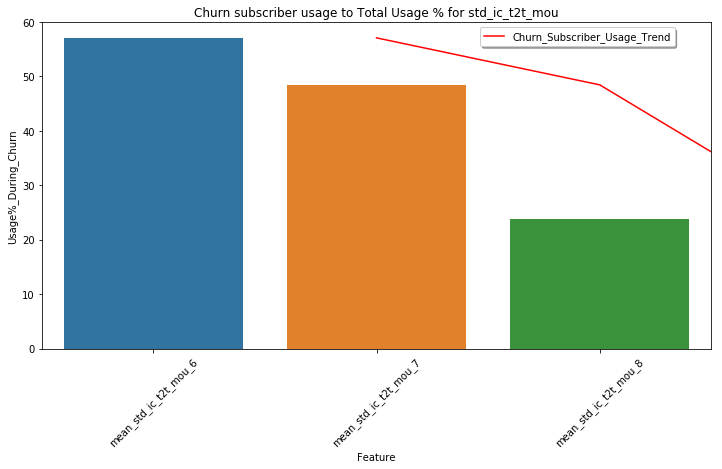

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_t2m_mou_6  31.742812  34.725886                52.24
2  mean_std_ic_t2m_mou_7  34.088722  27.870927                44.98
3  mean_std_ic_t2m_mou_8  32.549258  10.594920                24.56


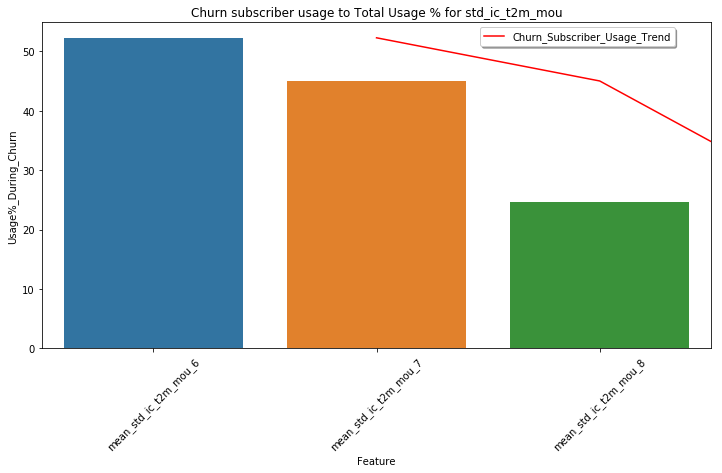

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_std_ic_t2f_mou_6   3.021584  1.520927                33.48
2  mean_std_ic_t2f_mou_7   3.131814  1.715869                35.40
3  mean_std_ic_t2f_mou_8   2.910733  0.548927                15.87


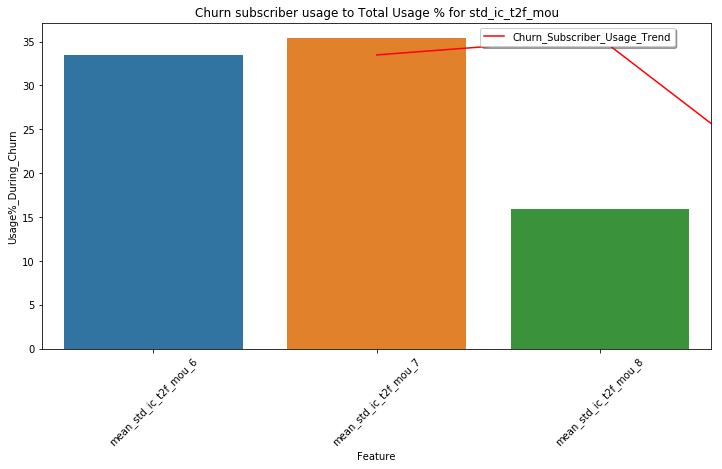

             Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_mou_6  50.507598  57.167194                53.09
2  mean_std_ic_mou_7  54.230225  45.563246                45.66
3  mean_std_ic_mou_8  51.594579  16.184270                23.88


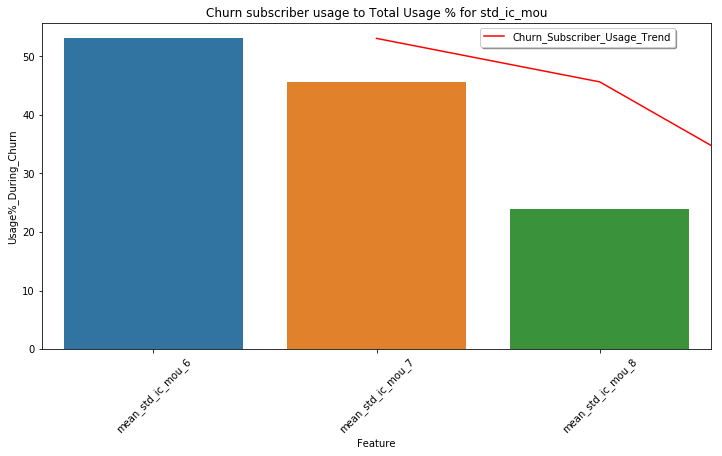

               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_ic_mou_6  314.654045  241.728993                43.45
2  mean_total_ic_mou_7  327.823473  194.325152                37.22
3  mean_total_ic_mou_8  319.203952   73.032190                18.62


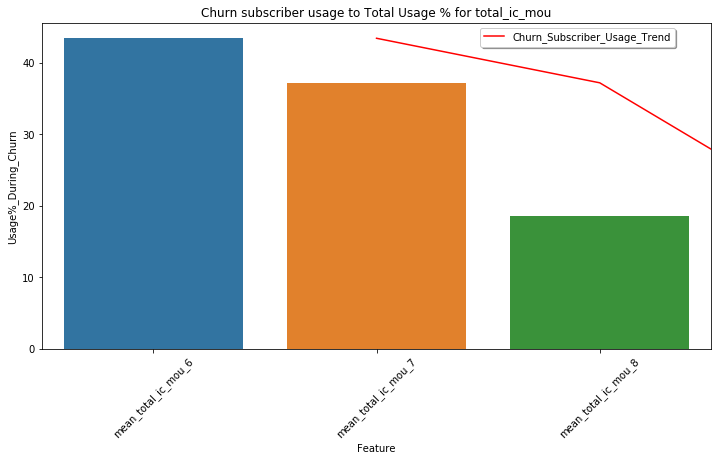

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_ic_mou_6   0.067053  0.063768                48.74
2  mean_spl_ic_mou_7   0.018383  0.015069                45.05
3  mean_spl_ic_mou_8   0.029726  0.007765                20.71


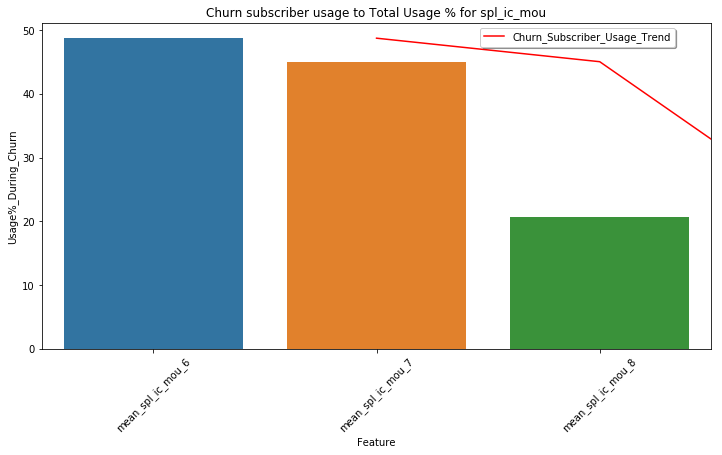

             Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_isd_ic_mou_6  11.101744  11.543709                50.98
2  mean_isd_ic_mou_7  12.538083  10.497308                45.57
3  mean_isd_ic_mou_8  12.491847   4.154374                24.96


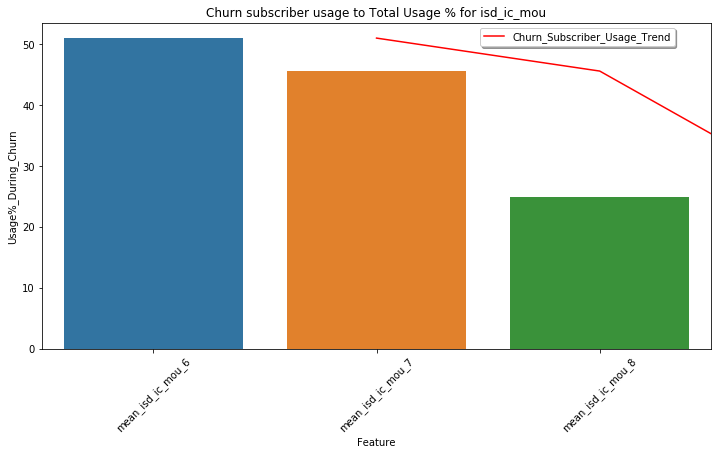

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_ic_others_6   1.208649  1.013159                45.60
2  mean_ic_others_7   1.555012  0.757813                32.77
3  mean_ic_others_8   1.330881  0.360612                21.32


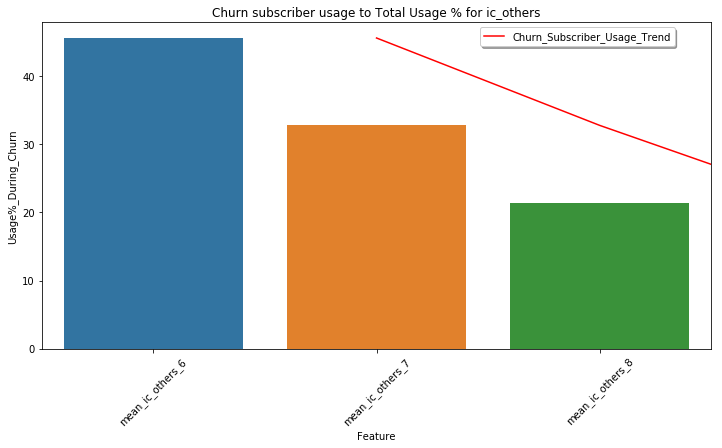

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_total_rech_num_6  11.898040  14.234256                54.47
2  mean_total_rech_num_7  11.951198  11.567474                49.18
3  mean_total_rech_num_8  10.731884   5.485121                33.82


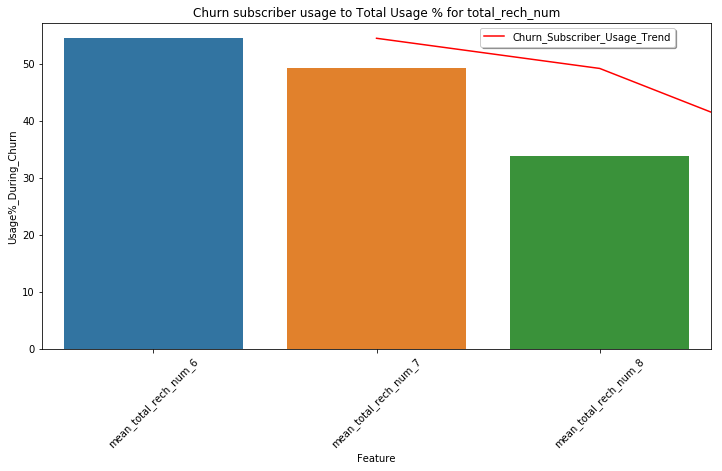

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_rech_amt_6  687.484329  793.664706                53.58
2  mean_total_rech_amt_7  703.582450  628.133218                47.17
3  mean_total_rech_amt_8  652.272066  254.312111                28.05


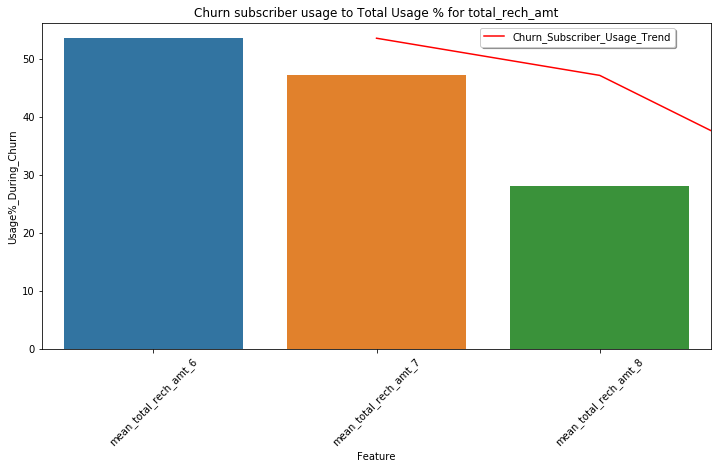

               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_max_rech_amt_6  171.901805  167.434256                49.34
2  mean_max_rech_amt_7  177.776736  156.472664                46.81
3  mean_max_rech_amt_8  171.226439   85.157785                33.21


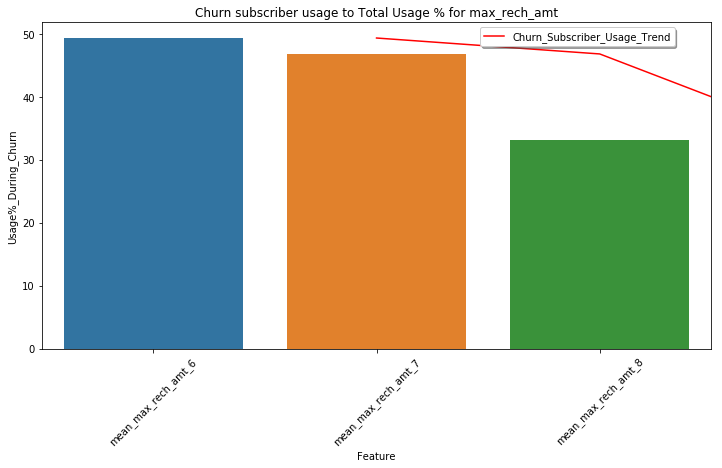

                   Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_last_day_rch_amt_6  104.686109  103.366090                49.68
2  mean_last_day_rch_amt_7  107.917679   80.798616                42.81
3  mean_last_day_rch_amt_8  102.025619   36.177163                26.18


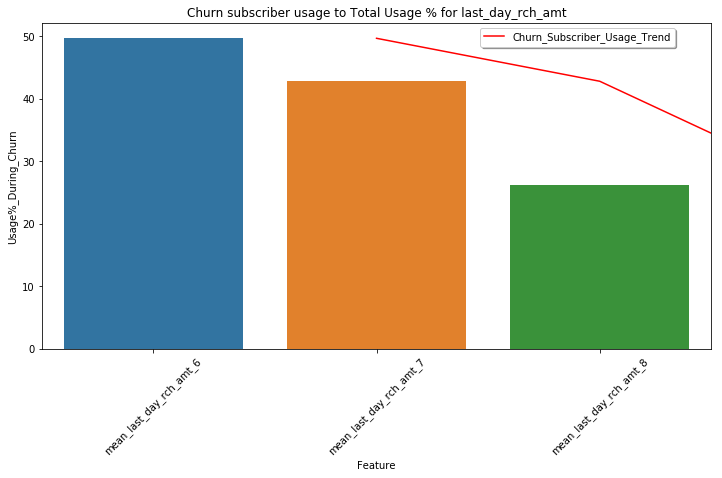

            Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_vol_2g_mb_6  80.646890  62.269166                43.57
2  mean_vol_2g_mb_7  81.141277  50.597211                38.41
3  mean_vol_2g_mb_8  74.913443  16.151678                17.74


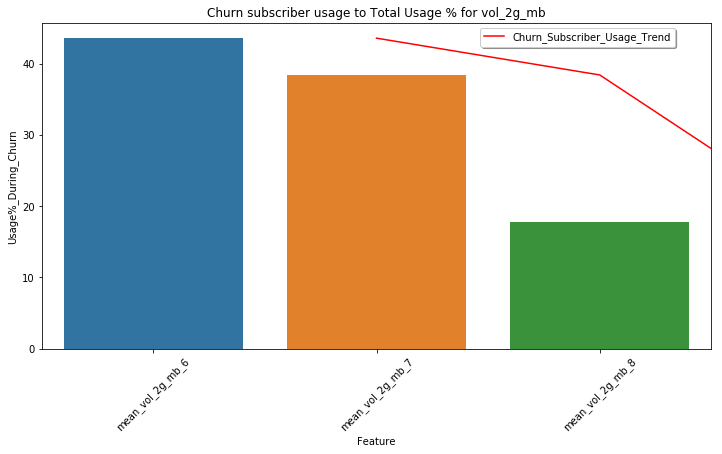

            Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_vol_3g_mb_6  266.155294  188.023197                41.40
2  mean_vol_3g_mb_7  290.785851  161.694100                35.74
3  mean_vol_3g_mb_8  292.427606   60.412035                17.12


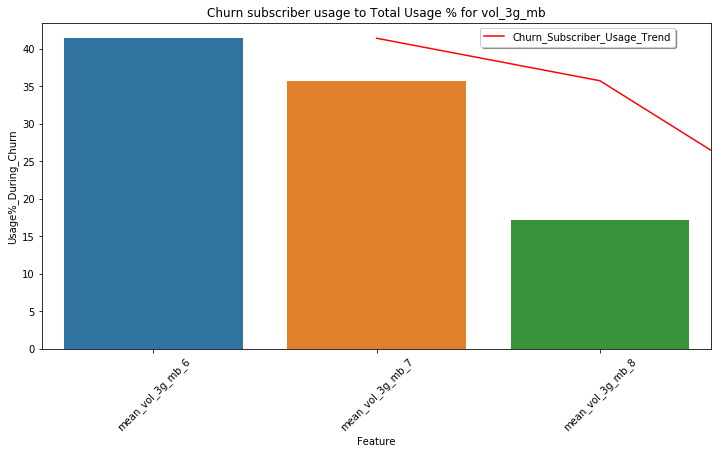

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_monthly_2g_6   0.131529  0.063322                32.50
2  mean_monthly_2g_7   0.139725  0.053633                27.74
3  mean_monthly_2g_8   0.124331  0.017993                12.64


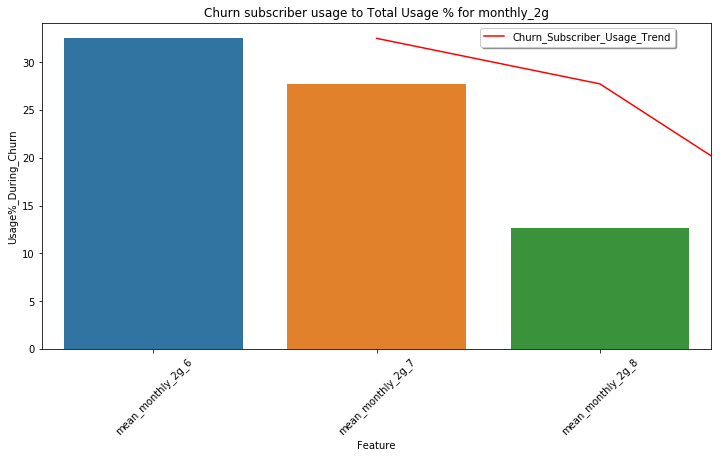

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_sachet_2g_6   0.507106  0.431488                45.97
2  mean_sachet_2g_7   0.604784  0.419031                40.93
3  mean_sachet_2g_8   0.651445  0.195848                23.11


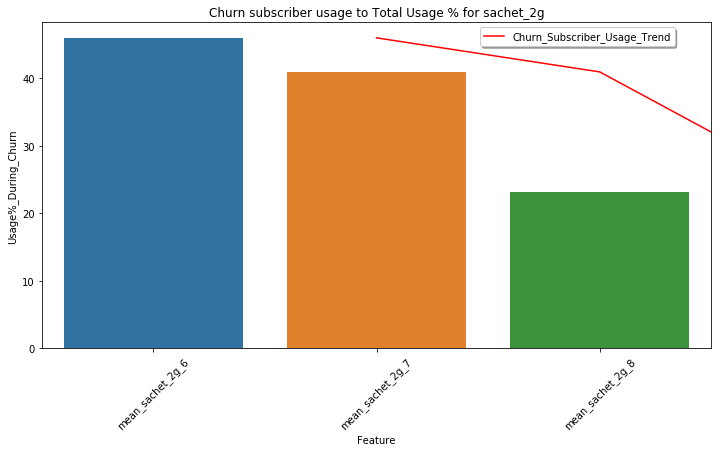

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_monthly_3g_6   0.178375  0.133564                42.82
2  mean_monthly_3g_7   0.194322  0.100692                34.13
3  mean_monthly_3g_8   0.188268  0.033218                15.00


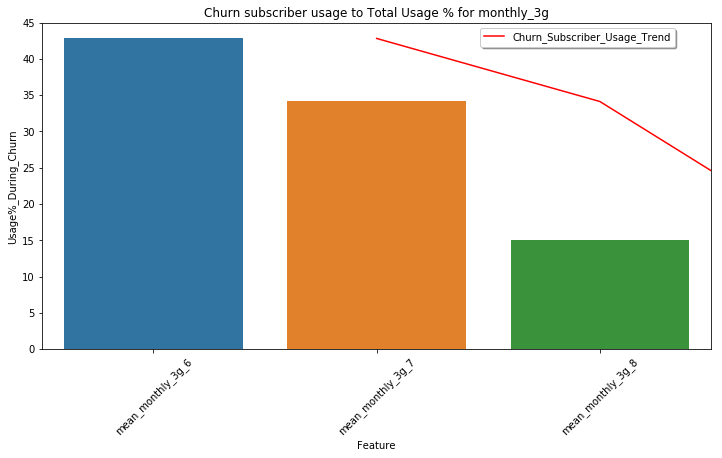

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_sachet_3g_6   0.139319  0.126298                47.55
2  mean_sachet_3g_7   0.151464  0.139792                48.00
3  mean_sachet_3g_8   0.150873  0.043253                22.28


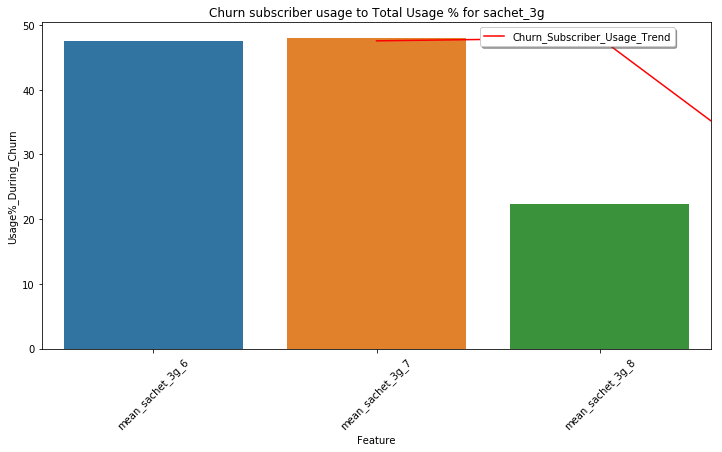

           Feature   Not-Churn      Churn  Usage%_During_Churn
1  mean_jun_vbc_3g  125.518181  83.326945                39.90
2  mean_jul_vbc_3g  141.598752  75.485363                34.77
3  mean_aug_vbc_3g  139.625424  34.408595                19.77


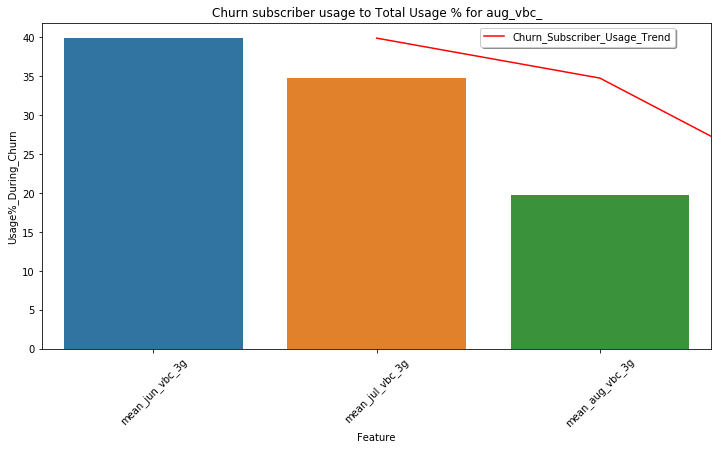

                        Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_days_from_LastRechage_6   3.240540   3.189965                49.61
2  mean_days_from_LastRechage_7   3.341246   5.923529                63.94
3  mean_days_from_LastRechage_8   4.002842  10.224913                71.87


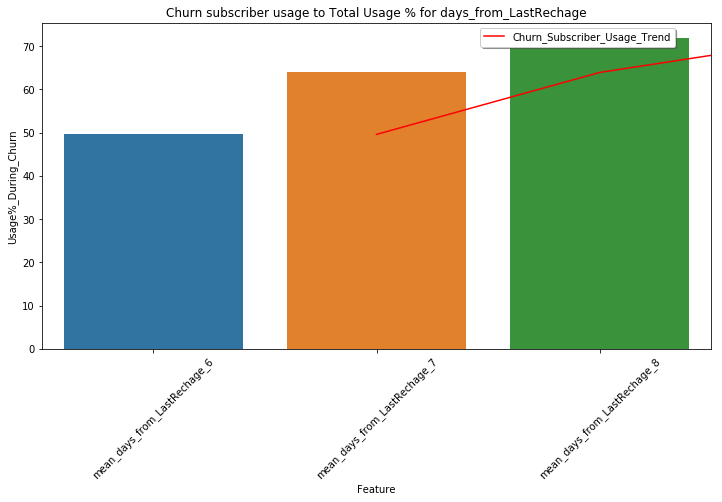

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_og_mou_Percent_6  52.708560  29.613170                35.97
2  mean_loc_og_mou_Percent_7  53.249801  28.960253                35.23
3  mean_loc_og_mou_Percent_8  53.475177  19.059464                26.28


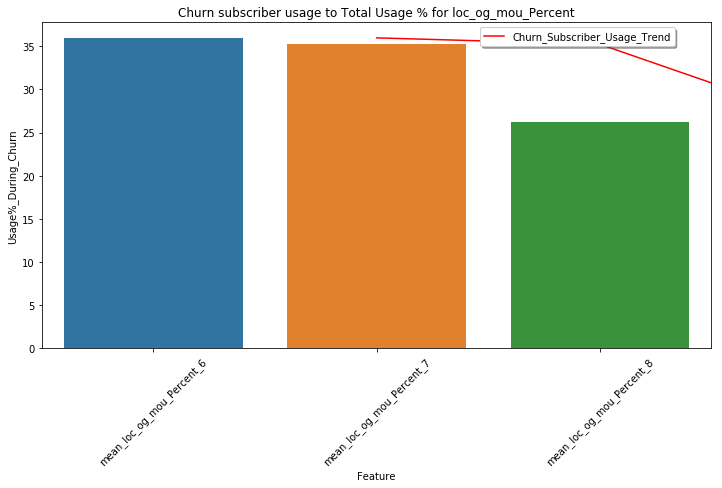

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_og_mou_Percent_6  41.938430  58.297256                58.16
2  mean_std_og_mou_Percent_7  42.079739  54.036623                56.22
3  mean_std_og_mou_Percent_8  40.548743  29.220855                41.88


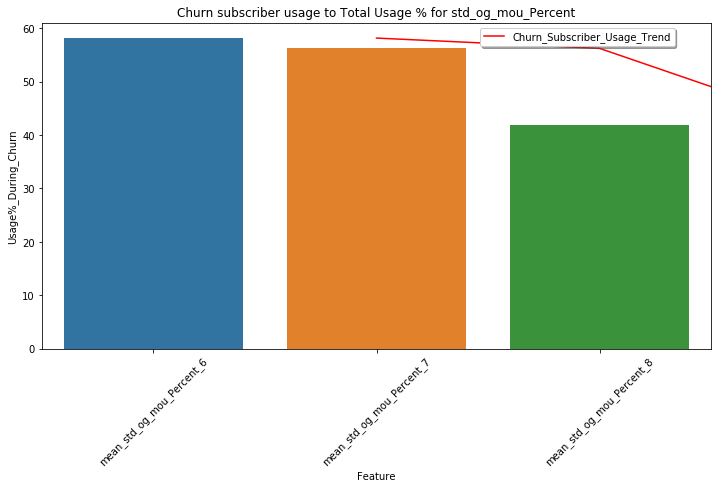

                     Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_og_mou_Percent_6   1.622290  1.652467                50.46
2  mean_spl_og_mou_Percent_7   1.935318  2.139343                52.50
3  mean_spl_og_mou_Percent_8   2.364349  2.698097                53.30


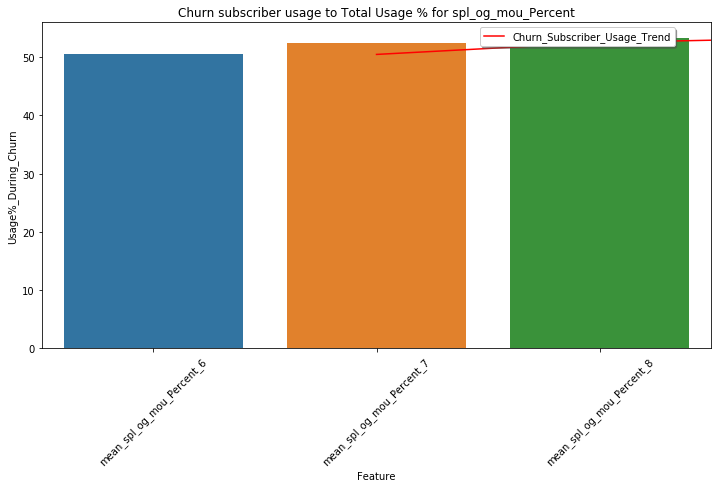

                    Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_og_others_Percent_6   0.177869  0.192052                51.92
2  mean_og_others_Percent_7   0.010068  0.009436                48.38
3  mean_og_others_Percent_8   0.015109  0.017152                53.17


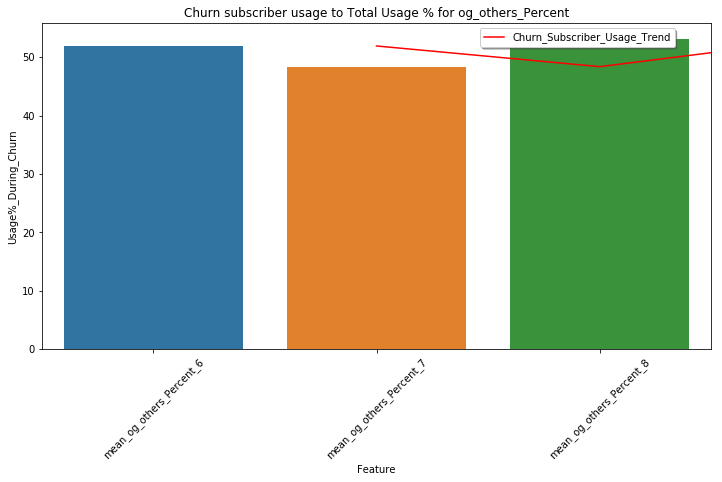

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_ic_mou_Percent_6  76.232645  63.287346                45.36
2  mean_loc_ic_mou_Percent_7  76.859255  60.519478                44.05
3  mean_loc_ic_mou_Percent_8  76.527610  37.483069                32.88


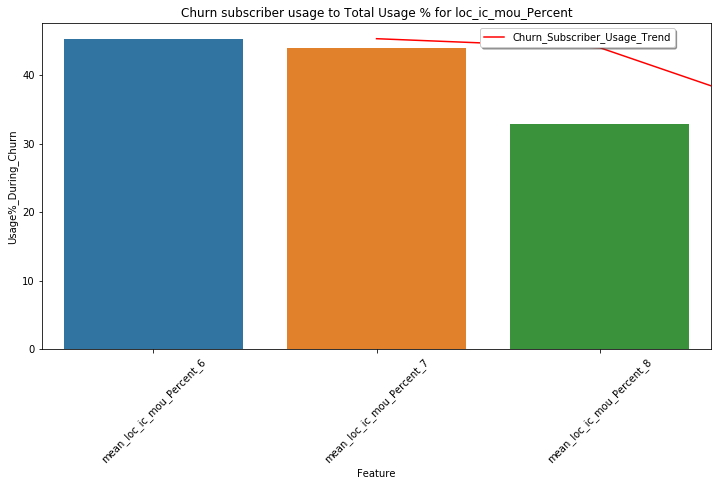

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_mou_Percent_6  17.794217  23.234218                56.63
2  mean_std_ic_mou_Percent_7  17.870203  21.189734                54.25
3  mean_std_ic_mou_Percent_8  17.391641  12.327917                41.48


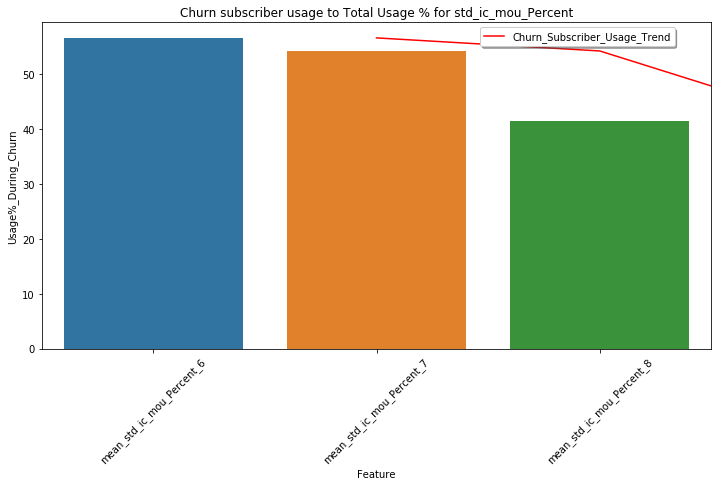

                     Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_ic_mou_Percent_6   0.074751  0.103464                58.06
2  mean_spl_ic_mou_Percent_7   0.026636  0.087253                76.61
3  mean_spl_ic_mou_Percent_8   0.042982  0.061021                58.67


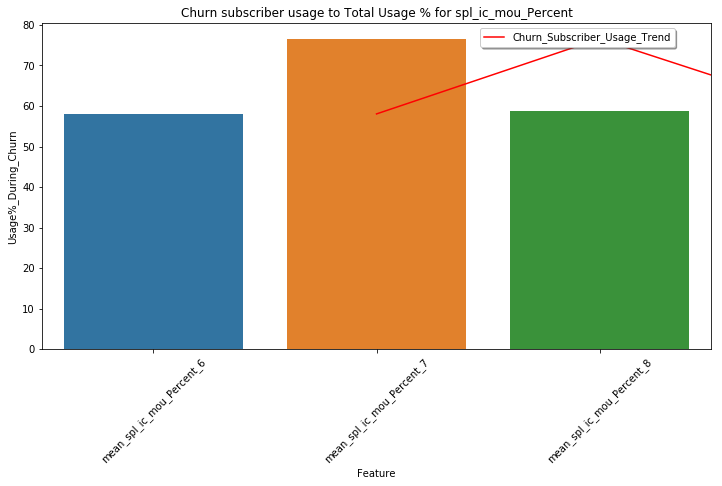

                    Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_ic_others_Percent_6   0.421887  0.419747                49.87
2  mean_ic_others_Percent_7   0.489235  0.506163                50.85
3  mean_ic_others_Percent_8   0.451854  0.256533                36.21


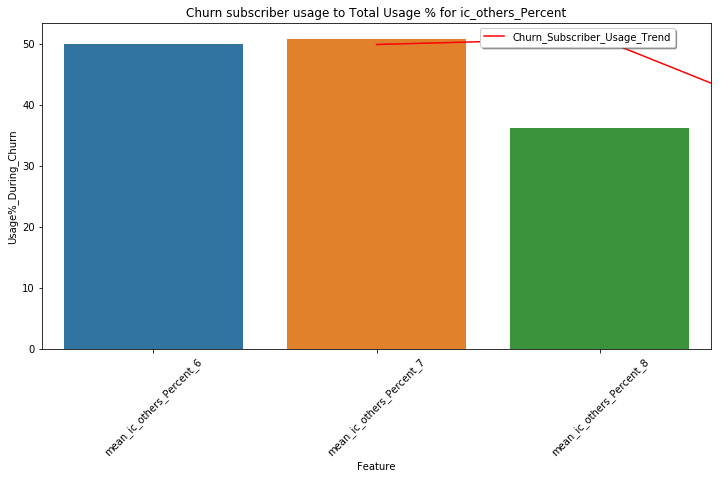

In [353]:
churnSubscriberUsageChangePercentage()

### Insight

* By Considering 8th Month as Churn Decision month and 6th and 7th as Good Month, following are the insight for all the features
    * Average Revenue per user (ARPU) is less in 8th month than 6th and 7th month. 
    * Onnet-Monthly-Usage (Onnet_MOU) is less in 8th Month than 6th and 7th Month.
    * Offnet-Montly-Usage (Offnet_MOU) is less in 8th Month than 6th and 7th Month.
    * ROAM_Incoming_MontlyUsage (Roam_IC_MOU) is not having any changes in good and decision period.
    * Roam_Outgoing_MonthlyUsage (Roam_OG_MOU) is not having any changes in good and decision perod.
    * Local Outgoing t2t Monthly Usage is less in 8th Month than 6th and 7th Month.
    * Local Outgoing t2m Monthly Usage is less in 8th month than 6th and 7th month.
    * Local Outgoing t2f Monthly Usage is less in 8th month than 6th and 7th month.
    * Local Outgoing t2c Monthly Usage is less in 8th month than 6th and 7th month.
    * Local Outgoing Monthly Usage is less in 8th month than 6th and 7th month.
    * STD outgoing t2t Monthly Usage is less in 8th month than 6th and 7th month.
    * STD outgoing t2m Monthly usage is less in 8th month than 6th and 7th month.
    * STD Outgoinh t2f Monthly Usage is less in 8th month than 6th and 7th month.
    * STD outgoing Monthly Usage is less in 8th month than 6th and 7th month.
    * ISD Outgoing Monthly Usage is less in 8th month than 6th and 7th month.
    * Special Outgoing Monthly Usage is less in 8th month than 6th and 7th month.
    * Outgoing Others is not having any changes in good and decision period.
    * Total Outgoing Monthly Usage is less in 8th Month than 6th and 7th month.
    * Local Incoming t2t Monthly Usage is less in 8th month than 6th and 7th month.
    * Local incoming t2m Monthly Usage is less in 8th month than 6th and 7th month.
    * Local incoming t2f Monthly Usage is less in 8th month than 6th and 7th month.
    * Local incoming usage Monthly Usage is less in 8th month than 6th and 7th month.
    * STD incoming t2t Monthly Usage is less in 8th month than 6th and 7th month.
    * STD incoming t2m monthly usage is less in 8th month than 6th and 7th month.
    * STD incoming t2f monthly usage is less in 8th month than 6th and 7th month.
    * STD incoming monthly usage is less in 8th month than 6th and 7th month.
    * Total Incoming Monthly Usage is less in 8th month than 6th and 7th month.
    * spl_ic_mou is less in 8th month than 6th and 7th month.
    * isd_ic_mou is less in 8th month than 6th and 7th month.
    * ic_others is less in 8th month than 6th and 7th month.
    * total_rech_num is less in 8th month than 6th and 7th month.
    * toal_rech_amt is less in 8th month than 6th and 7th month.
    * max_rech_amt is less in 8th month than 6th and 7th month.
    * last_rech_amt is less in 8th month than 6th and 7th month.
    * vol_2g_mb is less in 8th month than 6th and 7th month.
    * vol_3g_mb is less in 8th month than 6th and 7th month.
    * monthly_2g is less in 8th month than 6th and 7th month.
    * sachet_2g is less in 8th month than 6th and 7th month.
    * monhtly_3g is less in 8th month than 6th and 7th month.
    * sachet_3g is less in 8th month than 6th and 7th month.
    * vbc_3g is less in 8th month than 6th and 7th month.

#### * AOE feature trend in all the 3 months for churn and non-churn subscribers

In [ ]:
X1 = df.groupby('churn')['aon'].agg(['mean']).reset_index()
p = sns.barplot(x='churn', y='mean', data=X1)
p.set_xticklabels(['Not-Churn', 'Churn'],rotation=30)
p.set_ylabel('Average Age in Network')
plt.title('Average Age in Network between Churn and Not-Churn subscriber')
plt.show()


### Insight

* Churn subscriber is having less average AON than Non-Churn Subscriber. Hence subsriber is having high AON, then chances of Churn is less

# Data Modeling

#### * Data standardization and preparation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
X = (df.iloc[:,3:])
X = X.loc[:,X.columns != 'churn']
y = df.loc[:, 'churn']

#Standardization of Data
scaler = StandardScaler()
scaler.fit(X)
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#### * Basic Logistic Regression

In [ ]:
print("Number of Features ==> {}".format(len(X.columns)))

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score ==> {}".format(accuracy_score(y_test,y_pred)))